Using 120 runs from CR2192, train a CNN accepting $k$ timesteps of a simulation over $k$ channels to predict the Arrival Time of the CME (simulations only). The goal is to test if using the full image (simulation or observation) instead of summary statistics is as good a predictor of arrival times or arrival time error. Extensions? 

- Other quantities at 1 au

- Parameter inference

In [1]:
import sys
import torch
import torch.nn
from torch.nn.functional import relu
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.utils.data import random_split
import pandas as pd
import numpy as np
import os
import re
import sys
import logging
import torchvision
import torchvision.transforms as T

/Users/ajivani/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import torch.nn as nn

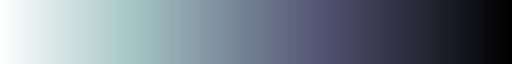

In [3]:
from sunpy.visualization import colormaps as cm

lc3_reg = cm.cmlist['soholasco3']
lc3_reg

lc3 = cm.cmlist['soholasco3'].reversed()
lc3

In [4]:
import time
import datetime
import argparse
from random import SystemRandom

from rich.progress import track
import tqdm

import matplotlib.pyplot as plt

import cnn_utils as cu

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import PowerTransformer

In [7]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [8]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

Filter out runs which arrive very late.

In [9]:
arr_times_data = pd.read_csv("./data_surrogate/UShift_CME3_120runs.csv")
arr_times_data = arr_times_data.dropna()

arr_times_data

,SIMID,shift,Tshock_sim,Tshock_obs
0,1,-18.0,70.0,52
2,3,-15.0,67.0,52
3,4,-7.0,59.0,52
4,5,-22.0,74.0,52
6,7,-4.0,56.0,52
...,...,...,...,...
114,116,7.0,45.0,52
115,117,19.0,33.0,52
116,118,16.0,36.0,52
117,119,5.0,47.0,52


In [10]:
data_sim_ids = arr_times_data['SIMID'].to_numpy()
data_arr_time = arr_times_data['Tshock_sim'].to_numpy()
data_shifts = arr_times_data['shift'].to_numpy()

In [11]:
# First split sim_ids, and arr_time into train and test.
# Based on this load param file for sims and index that

In [12]:
num_sim = len(data_sim_ids)
print(num_sim)

# train_size = np.int64(num_sim * 0.6)
# valid_size = np.int64(num_sim * 0.2)
# test_size = num_sim - train_size - valid_size
# print(train_size, valid_size, test_size)

train_frac, valid_frac, test_frac = 0.6, 0.2, 0.2

113


In [13]:
generator1 = torch.Generator().manual_seed(2024)
train_valid_test = random_split(data_sim_ids, 
                                [train_frac, valid_frac, test_frac],
                                # [train_size, valid_size, test_size],
                                generator=generator1)


In [14]:
train_idx = np.array(train_valid_test[0].indices)
valid_idx = np.array(train_valid_test[1].indices)
test_idx = np.array(train_valid_test[2].indices)

In [15]:
train_idx.shape, valid_idx.shape,test_idx.shape

((68,), (23,), (22,))

In [16]:
all_idx = np.concatenate((train_idx, valid_idx, test_idx), axis=0)

In [17]:
all_idx.min(), all_idx.max()

(0, 112)

In [18]:
data_arr_time

array([70., 67., 59., 74., 56., 88., 59., 85., 73., 86., 89., 52., 53.,
       78., 69., 67., 55., 61., 54., 59., 74., 71., 67., 51., 73., 56.,
       63., 51., 77., 62., 63., 72., 51., 49., 50., 74., 46., 71., 55.,
       61., 55., 67., 46., 65., 69., 56., 54., 51., 53., 64., 49., 44.,
       56., 50., 55., 47., 54., 73., 46., 43., 53., 66., 44., 38., 45.,
       54., 46., 46., 58., 50., 53., 47., 56., 43., 52., 39., 50., 63.,
       55., 40., 41., 56., 44., 38., 47., 62., 41., 40., 47., 38., 58.,
       39., 44., 37., 45., 49., 42., 39., 47., 35., 42., 33., 40., 40.,
       41., 36., 40., 41., 45., 33., 36., 47., 32.])

In [19]:
train_idx

array([  7,  43,  63,  33,  38,  73,  66,  20,  46,  80,  32,  21,  52,
        91, 101, 105,  35, 109,  19,  61,  82,  72,  92,  81,  90,   9,
        85,  39,  70,  40,  22,  45,  95,  24,  12,  97,   5,  67,  84,
        74, 110,  30,  71, 100,  37,  98, 102,  94,  57,  53,  75,  83,
       107,  42,  68,  69,  15,  59,  26,  10, 103, 112,  14,  56,  29,
       111,  87,  49])

In [20]:
train_sims = data_sim_ids[train_idx] - 1
val_sims = data_sim_ids[valid_idx] - 1
test_sims = data_sim_ids[test_idx] - 1

train_arr = data_arr_time[train_idx]
val_arr = data_arr_time[valid_idx]
test_arr = data_arr_time[test_idx]

pt = PowerTransformer()
pt.fit(train_arr.reshape(-1, 1))

train_arr_pt = pt.transform(train_arr.reshape(-1, 1))
val_arr_pt = pt.transform(val_arr.reshape(-1, 1))
test_arr_pt = pt.transform(test_arr.reshape(-1, 1))

train_shifts = data_shifts[train_idx]
val_shifts = data_shifts[valid_idx]
test_shifts = data_shifts[test_idx]

(array([ 7., 19., 21., 18., 16., 10.,  9.,  8.,  1.,  4.]),
 array([32. , 37.7, 43.4, 49.1, 54.8, 60.5, 66.2, 71.9, 77.6, 83.3, 89. ]),
 <BarContainer object of 10 artists>)

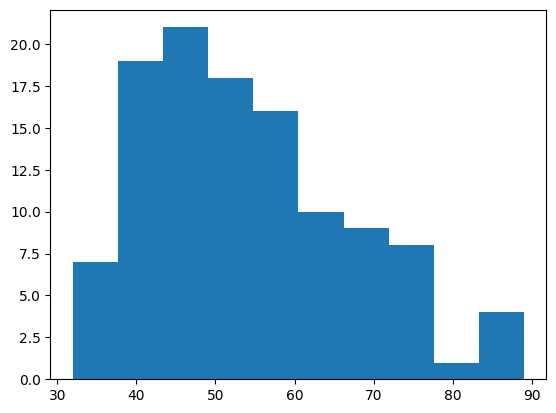

In [21]:
plt.hist(data_arr_time)

(array([ 3.,  4.,  9.,  8.,  9., 11.,  8.,  6.,  6.,  4.]),
 array([-2.06459814, -1.65771784, -1.25083753, -0.84395722, -0.43707691,
        -0.0301966 ,  0.37668371,  0.78356402,  1.19044432,  1.59732463,
         2.00420494]),
 <BarContainer object of 10 artists>)

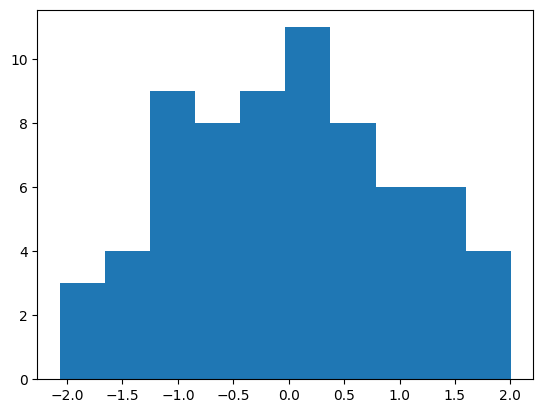

In [22]:
plt.hist(train_arr_pt.flatten())

### Load and Resize data (128 x 512) to (32 x 128)

In [23]:
raw_datafile = np.load("./data_surrogate/CR2192_120runs_C3_ratio_PolarTensor.npy")

In [24]:
raw_datafile.shape

(128, 512, 90, 120)

In [25]:
raw_min, raw_max = raw_datafile.min(), raw_datafile.max()
raw_min, raw_max

(0.799298967364635, 1.5)

In [26]:
train_data_raw = raw_datafile[:, :, :, train_idx]
val_data_raw = raw_datafile[:, :, :, valid_idx]
test_data_raw = raw_datafile[:, :, :, test_idx]

In [27]:
resize_dims = (16, 64)

train_data_resized = T.Resize(size=resize_dims,
                                  antialias=True
                                  )(torch.Tensor(train_data_raw.transpose(3, 2, 0, 1)))
    
val_data_resized = T.Resize(size=resize_dims,
                            antialias=True
                            )(torch.Tensor(val_data_raw.transpose(3, 2, 0, 1)))

test_data_resized = T.Resize(size=resize_dims,
                            antialias=True
                            )(torch.Tensor(test_data_raw.transpose(3, 2, 0, 1)))

In [28]:
max_train = torch.max(train_data_resized)
min_train = torch.min(train_data_resized)

max_train, min_train

(tensor(1.5000), tensor(0.8966))

In [29]:
all_timesteps = np.linspace(2, 180, 90, dtype=int)
tMinIdx = 50 # hardcoding for now, change later to accomodate variable length sequences
tMaxIdx = len(all_timesteps) - 1
nTimesteps = tMaxIdx - tMinIdx + 1



# scale time appropriately
tt = np.linspace(0, 1, tMaxIdx - tMinIdx + 1)
tpredict = torch.Tensor(tt).to(device)

nTimesteps, tpredict

(40,
 tensor([0.0000, 0.0256, 0.0513, 0.0769, 0.1026, 0.1282, 0.1538, 0.1795, 0.2051,
         0.2308, 0.2564, 0.2821, 0.3077, 0.3333, 0.3590, 0.3846, 0.4103, 0.4359,
         0.4615, 0.4872, 0.5128, 0.5385, 0.5641, 0.5897, 0.6154, 0.6410, 0.6667,
         0.6923, 0.7179, 0.7436, 0.7692, 0.7949, 0.8205, 0.8462, 0.8718, 0.8974,
         0.9231, 0.9487, 0.9744, 1.0000]))

In [30]:
train_data = (train_data_resized[:, tMinIdx:(tMaxIdx + 1), :, :] - min_train)/(max_train - min_train)
val_data = (val_data_resized[:, tMinIdx:(tMaxIdx + 1), :, :] - min_train)/(max_train - min_train)
test_data = (test_data_resized[:, tMinIdx:(tMaxIdx + 1), :, :] - min_train)/(max_train - min_train)

In [31]:
train_data.shape, val_data.shape, test_data.shape

(torch.Size([68, 40, 16, 64]),
 torch.Size([23, 40, 16, 64]),
 torch.Size([22, 40, 16, 64]))

In [32]:
train_data.max(), val_data.max(), test_data.max()

(tensor(1.), tensor(1.), tensor(1.))

### Concatenate parameters (optional)

In [33]:
raw_params = pd.read_csv("./data_surrogate/params_2192_120runs.csv")
raw_params = raw_params[["BStrength", "OrientationCme", "ApexHeight", "iHelicity"]]
raw_params

,BStrength,OrientationCme,ApexHeight,iHelicity
0,5.0417,347.475,0.8505,-1
1,5.1250,330.225,0.7196,1
2,6.7917,380.475,0.7482,1
3,5.3750,342.225,0.9123,-1
4,5.2917,322.725,0.8719,1
...,...,...,...,...
115,14.6250,300.225,0.6911,1
116,14.7083,371.475,0.9337,1
117,14.7917,348.225,0.7743,1
118,14.8750,312.975,0.7363,-1


In [34]:
raw_params.agg(['min', 'max'])

,BStrength,OrientationCme,ApexHeight,iHelicity
min,5.0417,294.975,0.6673,-1
max,14.9583,384.225,0.9504,1


In [35]:
raw_params_np = raw_params.to_numpy()

In [36]:
param_scaling = [15, 384, 0.95, 1]

### Train-test split and normalization

Use train_idx, valid_idx and test_idx

In [37]:
train_params_raw = raw_params_np[train_idx, :] / param_scaling
valid_params_raw = raw_params_np[valid_idx, :] / param_scaling
test_params_raw = raw_params_np[test_idx, :] / param_scaling

In [38]:
train_snaps = train_data.reshape((train_data.shape[0], train_data.shape[1], -1))
val_snaps = val_data.reshape((val_data.shape[0], val_data.shape[1], -1))
test_snaps = test_data.reshape((test_data.shape[0], test_data.shape[1], -1))

# repeat parameter values up to number of timesteps
train_params_ts = np.repeat(train_params_raw.reshape((train_params_raw.shape[0], train_params_raw.shape[1], 1)), nTimesteps, axis=2)
val_params_ts = np.repeat(valid_params_raw.reshape((valid_params_raw.shape[0], valid_params_raw.shape[1], 1)), nTimesteps, axis=2)
test_params_ts = np.repeat(test_params_raw.reshape((test_params_raw.shape[0], test_params_raw.shape[1], 1)), nTimesteps, axis=2)

# concatenate snaps and params
train_all = torch.cat((train_snaps, torch.Tensor(np.transpose(train_params_ts, (0, 2, 1)))), 2)
val_all = torch.cat((val_snaps, torch.Tensor(np.transpose(val_params_ts, (0, 2, 1)))), 2)
test_all = torch.cat((test_snaps, torch.Tensor(np.transpose(test_params_ts, (0, 2, 1)))), 2)

In [39]:
train_snaps.shape, val_snaps.shape

(torch.Size([68, 40, 1024]), torch.Size([23, 40, 1024]))

In [40]:
train_arr_ts = torch.Tensor(train_arr_pt.flatten())
val_arr_ts = torch.Tensor(val_arr_pt.flatten())
test_arr_ts = torch.Tensor(test_arr_pt.flatten())

In [41]:
# create lists
train_dataset = [(train_all[i:(i+1), :, :], tpredict, train_arr_ts[i]) for i in range(train_all.shape[0])]
val_dataset = [(val_all[i:(i+1), :, :], tpredict, val_arr_ts[i]) for i in range(val_all.shape[0])]
test_dataset = [(test_all[i:(i+1), :, :], tpredict, test_arr_ts[i]) for i in range(test_all.shape[0])]

In [47]:
train_dataset[1][0].shape, val_dataset[1][0].shape

(torch.Size([1, 40, 1028]), torch.Size([1, 40, 1028]))

In [50]:
len(train_dataset), len(val_dataset), len(test_dataset)

(68, 23, 22)

In [43]:
def inf_generator(iterable):
    """Allows training with DataLoaders in a single infinite loop:
        for i, (x, y) in enumerate(inf_generator(train_loader)):
    """
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()

In [44]:
def get_next_batch(dataloader, device=torch.device("cuda:0")):
    return dataloader.__next__()

### Coordinate concats? 

https://arxiv.org/pdf/1807.03247
Also see `coordconv_debug.py`

### Dataloaders (modify to select batch time and batch size)

In [45]:
import random

In [46]:
all_timesteps = np.linspace(2, 180, 90, dtype=int)
tMinIdx = 46 # hardcoding for now, change later to accomodate variable length sequences
tMaxIdx = len(all_timesteps) - 1
nTimesteps = tMaxIdx - tMinIdx + 1
tMaxVal = 180 # we have data up to 180 min
time_subset = all_timesteps[tMinIdx:(tMaxIdx + 1)]
tt = time_subset / tMaxVal
tpredict = torch.Tensor(tt).to(device)

steps_to_use = 5
starts_to_use = 3

valid_indices = list(range(nTimesteps - steps_to_use))

start_idx_all = sorted(random.sample(valid_indices, starts_to_use))

end_idx_all = []
for idx in start_idx_all:
    end_idx = min(idx + steps_to_use + 1, nTimesteps)
    end_idx_all.append(end_idx)

In [47]:
start_idx_all, end_idx_all

([4, 11, 17], [10, 17, 23])

In [48]:
def collate_fn_wl3(batch, 
                   # start_idx_all, 
                   # end_idx_all, 
                   device,
                   steps_to_use=3,
                   starts_to_use=3):
    """
    Return dictionary containing:
    Snapshots of observed data (based on start_idx_all, end_idx_all)
    These should be of the form b x t x nx x ny (time dim is 
    channel dim, use k timesteps for k input channels)
    Corresponding arrival times
    """
    all_timesteps = np.linspace(2, 180, 90, dtype=int)
    tMinIdx = 46 # hardcoding for now, change later to accomodate variable length sequences
    tMaxIdx = len(all_timesteps) - 1
    nTimesteps = tMaxIdx - tMinIdx + 1
    tMaxVal = 180 # we have data up to 180 min
    time_subset = all_timesteps[tMinIdx:(tMaxIdx + 1)]
    tt = time_subset / tMaxVal
    tpredict = torch.Tensor(tt).to(device)

    
    # starts_to_use = 4

    valid_indices = list(range(nTimesteps - steps_to_use))

    start_idx_all = sorted(random.sample(valid_indices, starts_to_use))

    end_idx_all = []
    for idx in start_idx_all:
        end_idx = min(idx + steps_to_use - 1, nTimesteps)
        end_idx_all.append(end_idx)
    
    all_data_dicts = []
    nICs = len(start_idx_all)
    for i, st, ed in zip(range(nICs), start_idx_all, end_idx_all):
        data = torch.zeros([len(batch), ed - st + 1, batch[0][0].shape[2]]).to(device)
        target = torch.zeros([len(batch), 1]).to(device)
        
        for b, (snap, ts, tarr) in enumerate(batch):
            data[b, :, :] = snap[:, st:(ed + 1), :]
            target[b, :] = tarr
            
        data_dict = {"observed_data": data,
                     "target": target,
                     "start_idx":st,
                     "end_idx":ed}
        
        
        all_data_dicts.append(data_dict)
        
        
    return all_data_dicts
    

In [49]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size = 4,
                              shuffle=True, 
                              collate_fn = lambda batch: collate_fn_wl3(batch, device))

In [50]:
val_dataloader = DataLoader(val_dataset, 
                              batch_size = 4,
                              shuffle=True, 
                              collate_fn = lambda batch: collate_fn_wl3(batch, device))

In [51]:
len(test_dataset)

22

In [52]:
test_dataloader = DataLoader(test_dataset, 
                              batch_size = len(test_dataset),
                              shuffle=False, 
                              collate_fn = lambda batch: collate_fn_wl3(batch, device))

In [53]:
16 * 64 + 4

1028

In [54]:
blah1 = train_dataloader.__iter__().__next__()
blah1[0]["observed_data"].shape

torch.Size([4, 3, 1028])

In [55]:
# blah[0]["target"], blah[1]["target"]

### Model and hyperparameters

In [56]:
# Linear model? One hidden layer, non-linear activations?

In [57]:
def get_sae(model, data_loader):
    SAE, n_examples = 0, 0
    with torch.no_grad():
        all_dicts = get_next_batch(inf_generator(data_loader))
        for batch in all_dicts: 
            images = batch['observed_data'].to(device)
            true_arrival = batch['target'].reshape(-1,1).to(device)
            pred_arrival = model.predict(images)
            SAE += torch.sum(torch.abs(pred_arrival - true_arrival))
            n_examples += true_arrival.size(0)
        return SAE/n_examples

In [58]:
class WLCNN(torch.nn.Module):

    def __init__(self, n_hidden_1,
                  n_hidden_2):
        super(WLCNN, self).__init__()
        in_channels = 3

        self.features = torch.nn.Sequential(
            nn.Conv2d(in_channels, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ELU(),
            nn.Conv2d(8, 16, kernel_size=5, stride=3, padding=3),
            nn.BatchNorm2d(16),
            nn.ELU(),
            # nn.ELU(),
            # nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=1),
            # nn.BatchNorm2d(64),
            # nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=1),
        )

        self.regressor = torch.nn.Sequential(
            nn.Linear(1280, n_hidden_1),
            nn.BatchNorm1d(n_hidden_1),
            nn.ELU(),
            nn.Dropout(p=0.5),
            nn.Linear(n_hidden_1, n_hidden_2),
            nn.BatchNorm1d(n_hidden_2),
            nn.Dropout(p=0.5),
            nn.ELU(),
            nn.Linear(n_hidden_2, 1)
        )

    def forward(self, x):
        x_ip = x[:, :, :1024].reshape(-1, 3, 16, 64)

        
        x_ft = self.features(x_ip)
        
        x_ft = torch.flatten(x_ft, 1)
        xpred = self.regressor(x_ft)
        return xpred

    def predict(self, x):
        xpred = self(x)
        return xpred

In [59]:
# blah = torch.rand(4, 5, 4100)
blah = torch.rand(4, 3, 16, 64)

In [60]:
# blah[:, :, :4096].reshape(-1, 5, 32, 128).shape

In [61]:
model = WLCNN(n_hidden_1=16, 
              n_hidden_2=8, 
              ).to(device)

In [62]:
model(blah)

tensor([[ 0.3561],
        [-0.0046],
        [-0.0244],
        [-0.4803]], grad_fn=<AddmmBackward0>)

In [63]:
# fts_blah = model.features(blah)

In [64]:
def getHC(Hin, Win, padding=(1, 1), dilation=(1, 1), kernel_size=(3, 3), stride=(1, 1)):
    """
    Calculate Hout and Wout when using `nn.Conv2d` on an image. Supply Hin, Win, padding, dilation,
    kernel_size and stride to calculate.
    """
    Hout = np.floor(((Hin + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1)/stride[0]) + 1)
    Wout = np.floor(((Win + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1)/stride[1]) + 1)
    return Hout, Wout


def getHCTransposed(Hin, Win, 
                    padding=(1, 1), 
                    dilation=(1, 1), 
                    kernel_size=(3, 3), 
                    stride=(1, 1),
                    output_padding=(0, 0)):
    """
    Calculate Hout and Wout when using `nn.ConvTranspose2d` on an image. Supply Hin, Win, padding, dilation,
    kernel_size and stride to calculate. Also supply output padding but we will keep it at zero so optional.
    """

    Hout = (Hin - 1) * stride[0] - 2 * padding[0] + dilation[0] * (kernel_size[0] - 1) + output_padding[0] + 1
    Wout = (Win - 1) * stride[1] - 2 * padding[1] + dilation[1] * (kernel_size[1] - 1) + output_padding[1] + 1
    return Hout, Wout


def getHCAdaptivePool(Hin, Win, padding=(1, 1), dilation=(1, 1), kernel_size=(3, 3), stride=(1, 1)):
    """
    Calculate Hout and Wout when using `nn.AdaptiveAvgPool` on an image. Supply Hin, Win, padding, dilation,
    kernel_size and stride to calculate.
    """
    Hout = np.floor(((Hin + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1)/stride[0]) + 1)
    Wout = np.floor(((Win + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1)/stride[1]) + 1)
    return Hout, Wout

### Continuous Model (NODE-CNN)

### Training and Results

In [65]:
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=0.005)

In [66]:
N_EPOCHS = 1000
train_losses = []
val_losses = []
for epoch in range(N_EPOCHS):
    model.train() # dropout behaves differently in train and eval mode
    
    train_dataloader = DataLoader(train_dataset, 
                              batch_size = 4,
                              shuffle=True, 
                              collate_fn = lambda batch: collate_fn_wl3(batch, device))
    
    val_dataloader = DataLoader(val_dataset, 
                              batch_size = 4,
                              shuffle=True, 
                              collate_fn = lambda batch: collate_fn_wl3(batch, device))
    
    all_batch_dicts = get_next_batch(inf_generator(train_dataloader))
    for bidx, bd in enumerate(all_batch_dicts):

        optimizer.zero_grad()
        imgs = bd["observed_data"].to(device)
        true_arrs = bd["target"].reshape(-1, 1).to(device)

        pred_arrs = model(imgs)
        pred_err = torch.sum(torch.abs(true_arrs - pred_arrs))

        pred_err.backward()
        optimizer.step()
        
        if bidx % 2 == 0:
            print("Iter: %03d/%03d | Batch %03d/%03d | Cost: %.4f"
                  % (epoch+1, N_EPOCHS, bidx,
                 len(train_dataloader), pred_err))
            
            
    model.eval()
    ep_loss = get_sae(model, train_dataloader)
    val_loss = get_sae(model, val_dataloader)
    
    train_losses.append(ep_loss)
    val_losses.append(val_loss)
    
    print('Train Loss: %.3f | Val Loss: %.3f'
              % (ep_loss, val_loss))

Iter: 001/1000 | Batch 000/017 | Cost: 2.8426
Iter: 001/1000 | Batch 002/017 | Cost: 0.5523
Train Loss: 1.111 | Val Loss: 0.524
Iter: 002/1000 | Batch 000/017 | Cost: 3.3510
Iter: 002/1000 | Batch 002/017 | Cost: 4.6350
Train Loss: 0.792 | Val Loss: 0.869
Iter: 003/1000 | Batch 000/017 | Cost: 4.1885
Iter: 003/1000 | Batch 002/017 | Cost: 2.4593
Train Loss: 0.932 | Val Loss: 0.746
Iter: 004/1000 | Batch 000/017 | Cost: 2.3017
Iter: 004/1000 | Batch 002/017 | Cost: 1.9235
Train Loss: 0.797 | Val Loss: 0.566
Iter: 005/1000 | Batch 000/017 | Cost: 3.1959
Iter: 005/1000 | Batch 002/017 | Cost: 4.4026
Train Loss: 1.116 | Val Loss: 1.013
Iter: 006/1000 | Batch 000/017 | Cost: 1.9027
Iter: 006/1000 | Batch 002/017 | Cost: 1.9373
Train Loss: 0.696 | Val Loss: 0.534
Iter: 007/1000 | Batch 000/017 | Cost: 3.5901
Iter: 007/1000 | Batch 002/017 | Cost: 4.9749
Train Loss: 0.608 | Val Loss: 1.013
Iter: 008/1000 | Batch 000/017 | Cost: 3.4981
Iter: 008/1000 | Batch 002/017 | Cost: 3.0480
Train Loss: 

In [67]:
model.eval()

WLCNN(
  (features): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Conv2d(8, 16, kernel_size=(5, 5), stride=(3, 3), padding=(3, 3))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0)
    (6): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (regressor): Sequential(
    (0): Linear(in_features=1280, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=8, out_features=1, bias=True

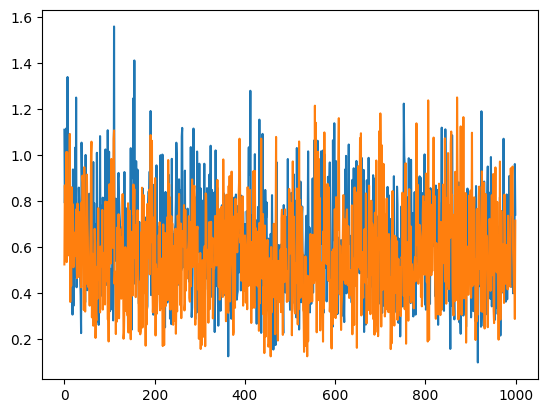

In [87]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')

In [68]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [69]:
count_parameters(model)

24177

In [70]:
test_data_dicts = get_next_batch(inf_generator(test_dataloader))

In [94]:
data_gen_train = inf_generator(train_dataloader)
batches_per_epoch = len(data_gen_train)

TypeError: object of type 'generator' has no len()

In [71]:
true_arrs = test_data_dicts[0]["target"]

In [72]:
true_arrs

tensor([[-0.8642],
        [ 1.3074],
        [-1.2955],
        [-1.0729],
        [-0.5739],
        [ 0.3093],
        [-0.0616],
        [-0.1415],
        [ 0.7623],
        [ 1.4990],
        [-0.2234],
        [-0.1415],
        [ 0.9929],
        [ 0.9929],
        [ 1.5449],
        [ 1.1545],
        [ 1.2574],
        [ 0.0921],
        [ 0.1662],
        [ 1.3566],
        [-0.0616],
        [ 0.0162]])

In [73]:
true_arrs_t = pt.inverse_transform(true_arrs)

In [74]:
true_arrs_t

array([[42.00000017],
       [73.00000063],
       [37.99999988],
       [40.00000032],
       [44.99999986],
       [56.00000001],
       [51.00000002],
       [50.00000005],
       [63.00000009],
       [76.9999998 ],
       [49.00000008],
       [50.00000005],
       [66.99999983],
       [66.99999983],
       [78.0000003 ],
       [70.00000053],
       [71.99999997],
       [52.99999998],
       [54.00000007],
       [74.00000097],
       [51.00000002],
       [52.        ]])

In [75]:
test_preds1 = model(test_data_dicts[0]["observed_data"])

In [76]:
test_preds_t1 = pt.inverse_transform(test_preds1.detach().numpy())

In [77]:
test_preds2 = model(test_data_dicts[1]["observed_data"])
test_preds_t2 = pt.inverse_transform(test_preds2.detach().numpy())

In [78]:
test_preds3 = model(test_data_dicts[2]["observed_data"])
test_preds_t3 = pt.inverse_transform(test_preds3.detach().numpy())

Text(0, 0.5, 'Predicted arrival of sim (hrs)')

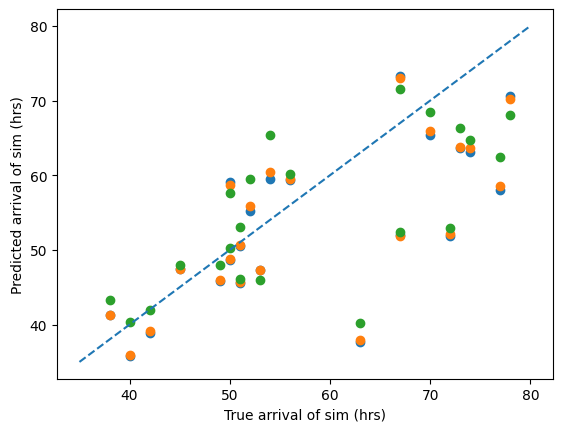

In [85]:
plt.scatter(true_arrs_t, test_preds_t1)
plt.scatter(true_arrs_t, test_preds_t2)
plt.scatter(true_arrs_t, test_preds_t3)
plt.plot(np.linspace(35, 80, 40), np.linspace(35, 80, 40), '--')
plt.xlabel("True arrival of sim (hrs)")
plt.ylabel("Predicted arrival of sim (hrs)")

In [86]:
print(np.corrcoef(true_arrs_t.T, test_preds_t1.T)[1][0])
print(np.corrcoef(true_arrs_t.T, test_preds_t2.T)[1][0])
print(np.corrcoef(true_arrs_t.T, test_preds_t3.T)[1][0])

0.7017538909701525
0.7055397411844198
0.6954690908984974
